In [1]:
import ctypes
from ctypes import *
from numpy.ctypeslib import ndpointer
import numpy as np
import matplotlib.pyplot as plt
import numba

In [2]:
!gcc -shared -O2 -fPIC ode.c -o libode.so

In [3]:
#load our C library, it's as simple as that!
lib = ctypes.CDLL("libode.so")
#rename C-based solve_ode() function into solve_ode_c()
solve_ode_c = lib.solve_ode
#in order to call a C function, we need to define:
# * the return data type
solve_ode_c.restype = None
# * function argument types
solve_ode_c.argtypes = [
    ndpointer(ctypes.c_double), 
    ndpointer(ctypes.c_double),
    ctypes.c_double,
    ctypes.c_int,
    ctypes.c_int,
    ctypes.c_int,
    ndpointer(ctypes.c_double),
    ctypes.CFUNCTYPE(None,c_double, POINTER(c_double), POINTER(c_double), POINTER(c_double))
]

#In order to "hide" from the end user the C "guts" of the library, 
#let's create a python "wrapper function" for our ODE solver
def solve_ode(fun, t_span, nsteps, z0, method = "RK4", args = None ):
    """
    Takes in the right-hand side function fun, the time range t_span, 
    the number of time steps nsteps, and the initial condition vector z0.
    
    Keyword arguments: 
    method -- one of "Euler", "Euler-Cromer", "RK2", "RK4" ODE solution methods
    args   -- arguments to pass to the right-hand side function fun()
    
    Returns: the pair t,z of time and solution vector.
    """
    t_span = np.asarray(t_span,dtype=np.double)
    t = np.linspace(t_span[0],t_span[1],nsteps+1,dtype=np.double)
    nvar = len(z0)
    z = np.zeros([nsteps+1,nvar],dtype=np.double,order='C')
    #assign initial conditions
    z0 = np.asarray(z0,dtype=np.double)
    z[0,:] = z0
    #check if the supplied function is numba-based CFunc
    if("ctypes" in dir(fun)):
        #numba-based, we can use it right away
        fun_c = fun.ctypes
    else:
        #otherwise, we need to wrap the python function into CFUNCTYPE
        FUNCTYPE = CFUNCTYPE(None,c_double, POINTER(c_double), POINTER(c_double), POINTER(c_double))
        #create a C-compatible function pointer
        fun_c = FUNCTYPE(fun)
    #compute preliminaries to call the C function library
    dt = (t_span[1]-t_span[0])/nsteps
    if args is not None: args = np.asarray(args,dtype=np.double)
    if method in ["RK2", "RKO2"]:
        order = 2
    elif method in ["Euler"]:
        order = 1
    elif method in ["Euler-Cromer"]:
        order = -1
    elif method in ["Velocity Verlet"]:
        order = 13
    elif method in ["Leapfrog"]:
        order = 5
    elif method in ["RK4"]:
        order = 4
    elif method in ["Yoshida4"]:
        order = 6
    else:
        #default
        order = 4
    
    #make a call to the C library function
    solve_ode_c(t,z,dt,nsteps,nvar,order,args,fun_c)

    return t,z

## Define the right-hand side function: $\frac{d\vec z}{dt} = \vec f(t,\vec z)$

In [4]:
#This has been updated to use numba, which compiles the below function on the fly
#and substantially speeds up the ODE integration
from numba import cfunc, types

c_sig = types.void(types.double,
                   types.CPointer(types.double),
                   types.CPointer(types.double),
                   types.CPointer(types.double))

@cfunc(c_sig)
def func(t,z,params,dzdt):
    """
    Takes the time and solution vector z, as well as parameters in the params array, 
    and populates the dzdt array with the values of the right-hand side function f(t,z).
    
    This function returns the right-hand side f(t,z) for a planet subject to graviational
    force due to the center body with GM_S = 4 pi^2 * params[0]
    
    Returns: nothing
    """
    x  = z[0]
    Vx = z[1]
    y  = z[2]
    Vy = z[3]
    
    r = np.sqrt(x**2 + y**2)
    
    dzdt[0] = Vx
    dzdt[1] = -4. * (np.pi ** 2) * params[0] * x / (r ** 3)
    dzdt[2] = Vy
    dzdt[3] = -4. * (np.pi ** 2) * params[0] * y / (r ** 3)

# Test particle orbiting the Sun

## Initial conditions: $x=1, \ y=0, \ V_x = 0, \ V_y = 2\pi$

In [5]:
tf = 100.
dt = 0.001
nsteps = int(tf/dt)
t,z = solve_ode(func,[0.,tf], nsteps, [1.,0.,0.,2*np.pi], args=[1], 
                #method="RK4") 
                #method="Leapfrog") 
                #method="Velocity Verlet")
                method="Yoshida4")
x,vx,y,vy = z.T
print(nsteps)

100000


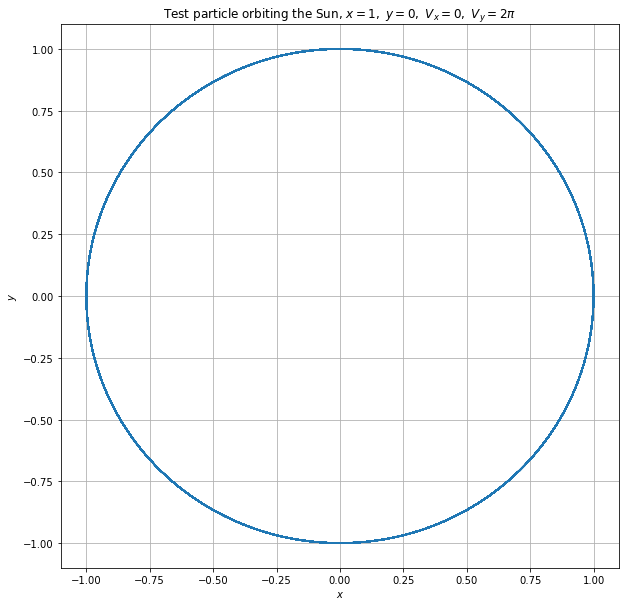

In [6]:
plt.figure(figsize=(10,10))
plt.title(r"Test particle orbiting the Sun, $x=1,\ y=0, \ V_x=0, \ V_y = 2 \pi$")
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")

plt.plot(x,y)
#plt.legend(loc="upper right")
plt.grid()

plt.savefig("xytest.png")

No handles with labels found to put in legend.


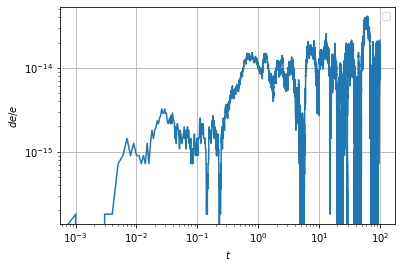

In [7]:
r = (x**2+y**2)**0.5
GM=4*np.pi**2
energy = 0.5*(vx**2+vy**2)-GM/r
ax2 = plt.gca()
ax2.loglog(t,np.abs((energy-energy[0])/energy[0]))
ax2.grid()
ax2.set_xlabel("$t$")
ax2.set_ylabel("$de/e$")
ax2.legend()

In [16]:
#This has been updated to use numba, which compiles the below function on the fly
#and substantially speeds up the ODE integration
from numba import cfunc, types

c_sig = types.void(types.double,
                   types.CPointer(types.double),
                   types.CPointer(types.double),
                   types.CPointer(types.double))

@cfunc(c_sig)
def func(t,a,params,dadt):
    """
    Takes the time t and solution vector a, as well as parameters in the params array, 
    and returns the right-hand side function, dadt
    """
    x  = a[0]
    vx = a[1]
    y  = a[2]
    vy = a[3]
    r = (x**2+y**2)**0.5
    GM = params[0]
    dadt[0] = vx
    dadt[1] = -GM*x/r**3
    dadt[2] = vy
    dadt[3] = -GM*y/r**3    

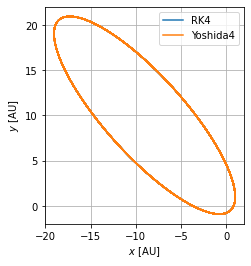

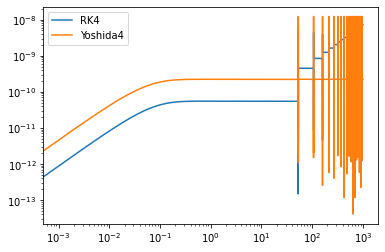

In [24]:
fig1 = plt.figure()
ax1 = plt.gca()
fig2 = plt.figure()
ax2 = plt.gca()
dt = 0.001
nsteps = int(1000/dt)

GM = 4*np.pi**2
for method in ["RK4", "Yoshida4"]: #"RK2","Leapfrog",  
    t,a = solve_ode(func,[0.,1000.], nsteps, [1,0,1,2*np.pi+1], args=[GM], method=method)
    x,vx,y,vy = a.T
    r = (x**2+y**2)**0.5
    energy = 0.5*(vx**2+vy**2)-GM/r
    ax1.plot(x,y,label=r"%s" % method)
    ax2.loglog(t,np.abs((energy-energy[0])/energy[0]),label=r"%s" % method)
    #ax2.scatter(t,np.abs((energy-energy[0])/energy[0]),label=r"%s" % method,s=1)
ax1.legend()
ax1.set_aspect(1.)
ax1.grid(b=1)
ax1.set_xlabel(r"$x$ [AU]")
ax1.set_ylabel(r"$y$ [AU]")
fig1.savefig("orbits.png")
ax2.legend()
#ax2.set_xscale("log")
#ax2.set_yscale("log")

fig2.savefig("denergy.png")

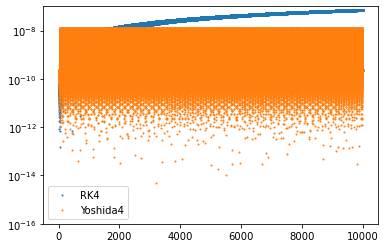

In [28]:
dt = 0.001
nsteps = int(10000/dt)

GM = 4*np.pi**2
for method in ["RK4", "Yoshida4"]: #"RK2","Leapfrog",  
    t,a = solve_ode(func,[0.,10000.], nsteps, [1,0,1,2*np.pi+1], args=[GM], method=method)
    x,vx,y,vy = a.T
    r = (x**2+y**2)**0.5
    energy = 0.5*(vx**2+vy**2)-GM/r
    plt.scatter(t,np.abs((energy-energy[0])/energy[0]),label=r"%s" % method,s=1)

plt.legend()
#plt.xscale("log")
plt.yscale("log")
plt.ylim(0.0000000000000001, 0.0000001)

plt.savefig("dedt.png")

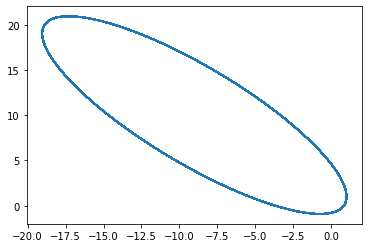

In [27]:
plt.plot(x,y)

## The period of the orbit

In [13]:
# pick time when the planet is at (1,0)
# note that to find the scale of the distances, I found x[3] - x[2]. 
# it is of the 9th order so that I compared x-1 and y with 10^(-9)
which = ((np.abs(x - 1) < np.power(10.,-3.)) * (np.abs(y-1) < np.power(10.,-3.)))

# choose times when the planet at (1,0), find the discrete difference, and find the average of this number
T = np.average(np.diff(t[which]))
print("The period is %0.2f" %T)

The period is 1.33


We expect the result be 1 year, and it is the same as we get from the simulation.

## Initial conditions: $x=1, \ y=0, \ V_x = 0, \ V_y = 2\pi$ and $x=1, \ y=0, \ V_x = 1, \ V_y = 2\pi + 1$

In [22]:
dt = 0.0001
nsteps = int(1000/dt)
t,z1 = solve_ode(func,[0.,1000.], nsteps, [1.,0.,0.,2*np.pi], args=[1], method="Velocity Verlet")
x1,Vx1,y1,Vy1 = z1.T

t,z2 = solve_ode(func,[0.,1000.], nsteps, [1.,1.,0.,2*np.pi+1], args=[1], method="Velocity Verlet")
x2,Vx2,y2,Vy2 = z2.T

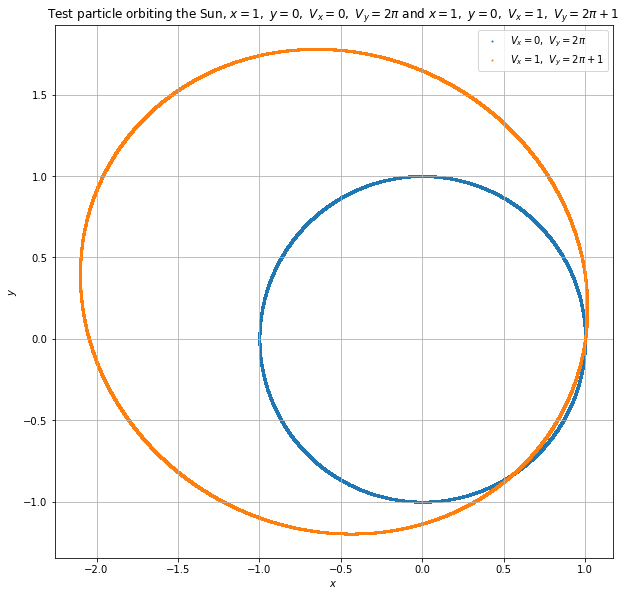

In [23]:
plt.figure(figsize=(10,10))
plt.title(r"Test particle orbiting the Sun, $x=1,\ y=0, \ V_x=0, \ V_y = 2 \pi$ and $x=1, \ y=0, \ V_x = 1, \ V_y = 2\pi + 1$")
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")

plt.scatter(x1,y1,label="$V_x = 0, \ V_y = 2\pi$",s=1)
plt.scatter(x2,y2,label="$V_x = 1, \ V_y = 2\pi + 1$",s=1)
plt.legend(loc="upper right")
plt.grid()
plt.gca().set_aspect(1.0)

plt.savefig("xytest_circle_ellipse.png")

## Functions ellipse_to_xy and xy_to_ellipse

In [15]:
def ellipse_to_xy(a,e,theta,thetaE):
    """
    Takes the particle's position relative to an ellipse and parameters of the ellipse a,e,theta,theta_E.
    This function returns the Cartesian variables x,V_x,y,V_y.
    
    Returns x,Vx,y,Vy
    """
    # radius using angle theta
    r = a * (1 - e**2) / (1 + e * np.cos(theta - thetaE))
    
    # angular momentum per mass
    h = 2. * np.pi * np.sqrt(np.abs(a * (1. - e **2)))
    
    # energy per mass
    u = - 2. * (np.pi ** 2) / a 
    
    # speed of the particle
    V = np.sqrt(np.abs(2. * u + 8. * (np.pi ** 2) / r)) 
    
    # let Vx = V cos alpha, Vy = V sin alpha
    # buff = alpha - theta
    # when the radial velocity is positive (the planet goes from its periapse to apoapse = sin(theta-theta_E) > 0)
    # alpha - theta should be less then pi/2
    buff = np.pi*(np.sin(theta - thetaE) < 0.) + np.power(-1., np.sin(theta - thetaE) < 0.) * np.arcsin(h / (r * V))
    alpha = theta + buff
        
    # x and y
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    # Vx and Vy
    Vx = V * np.cos(alpha)
    Vy = V * np.sin(alpha)
    
    return x,Vx,y,Vy

In [19]:
#import pdb
def xy_to_ellipse(x,Vx,y,Vy):
    """
    Takes the Cartesian variables.
    This function returns the particle's position relative to an ellipse and parameters of the ellipse.
    
    Returns a,e,theta,theta_E
    """
    # radius using x and y
    r = np.sqrt(x ** 2 + y ** 2)
    
    # speed of the particle
    V = np.sqrt(Vx ** 2 + Vy ** 2)
    
    # angular momentum per mass
    h = x * Vy - y * Vx
    
    # energy per mass
    u = (V ** 2) / 2. - 4. * (np.pi ** 2) / r
    
    # semi-major axis
    a = -2. * ((np.pi) ** 2) / u
    
    # eccentricity of the elliptical orbit, added absolute value
    e = np.sqrt(np.abs(1 - ((h / (2. * np.pi)) ** 2 )/ a))
    
    # theta
    theta = np.arctan2(y,x)
    
    # theta_E, compute e*cos(theta - thetaE) first
    buff = a * (1. - e ** 2) / r - 1.
    
    # divide buff/e and output 0 if it is a circular orbit
    buff_cos = np.divide(buff, e, out=np.zeros_like(buff), where=(e > np.power(10.,-5.)))
    
    #if (buff_cos < -1.).sum() or (buff_cos > 1.).sum():
        #pdb.set_trace()
    
    #to make sure that arccos takes values less than 1 and greater than -1
    buff_cos[buff_cos < -1.] = -1.
    buff_cos[buff_cos > 1.] = 1.
    
    delta = np.arccos(buff_cos)
    
    # change the sign if the radial velocity is negative
    delta *= np.power(-1.,(x * Vx + y * Vy) < 0.)
    thetaE = theta - delta
    
    # set thetaE to 0 if it is a circular orbit
    thetaE *= (e > np.power(10.,-5.))
    
    # fix to add 2pi or subtract 2pi if thetaE isn't between -pi and pi
    thetaE -= (thetaE > np.pi) * 2 * np.pi
    thetaE += (thetaE < -np.pi) * 2 * np.pi
    
    return a,e,theta,thetaE

In [29]:
w1 = - np.power(2, 1./3.) / (2. - np.power(2, 1./3.))
print("%.25f" % w1)

-1.7024143839193153215916254


In [30]:
w2 = 1. / (2. - np.power(2, 1./3.))
print("%.25f" % w2)

1.3512071919596577718181152
